In [ ]:
%matplotlib inline

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim
import time
import datetime

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

LR = 1e-3
LR_LBFGS = 1
LR_RPROP = 1
BETAS = (0.9, 0.99)
MOMENTUM = 0.99
EPS = 1e-4
WD = 1e-3
EPOCHS = 20
BATCH_SIZE = 100
SPLIT = 10
WORKERS = 2
PATH = './cifar_net_.pth'

In [ ]:
transform = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) #Normalize all the images
                               ])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_len = len(trainset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=WORKERS)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

test_len = len(testset)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=WORKERS)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(f'train_len: {train_len}, test_len: {test_len}')

train_len: 50000, test_len: 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(100, 3, 32, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

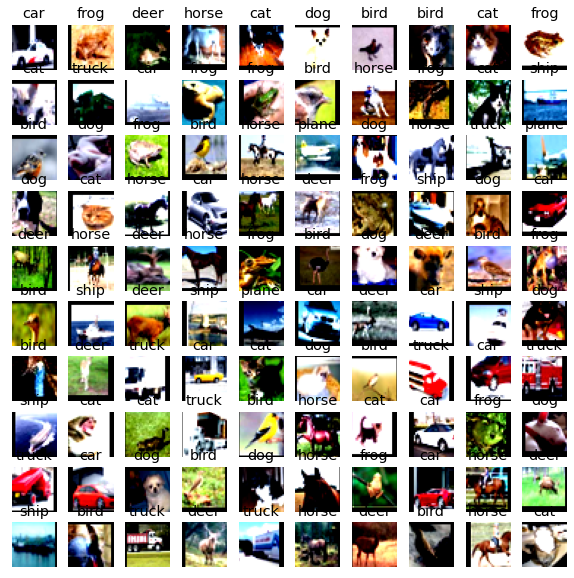

In [ ]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Converting images to numpy arrays to plot
images = images.numpy()

fig = plt.figure(figsize=(BATCH_SIZE/SPLIT,SPLIT))

print(images.shape)

for index in np.arange(BATCH_SIZE):
    ax = fig.add_subplot(BATCH_SIZE/SPLIT,SPLIT,index+1,xticks=[], yticks=[])
    imshow(images[index])
    ax.set_title(classes[labels[index]])


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [ ]:
net = Net().to(device)
net

Net(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
def closure():
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    return loss

state_dictionaries = {}
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

def train(opt):
    global inputs, labels, outputs, loss
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    print('Starting to train with optimizer: ', type(opt).__name__)
    start = time.time()
    for epoch in range(EPOCHS):  # loop over the dataset multiple times
        running_loss = 0.0
        running_corrects = 0.0
        val_running_loss = 0.0
        val_running_corrects = 0.0
        for inputs, labels in trainloader:
            inputs = inputs.to(device) # input to device as our model is running in mentioned device.
            labels = labels.to(device)
            # Forward Pass
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # Backward Pass and optimize
            opt.step(closure)

            _, preds = torch.max(outputs, 1)

            # print statistics
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            end = time.time()
        else:
          with torch.no_grad(): # we do not need gradient for validation.
            for val_inputs, val_labels in testloader:
              val_inputs = val_inputs.to(device)
              val_labels = val_labels.to(device)
              val_outputs = net(val_inputs)
              val_loss = criterion(val_outputs, val_labels)
              
              _, val_preds = torch.max(val_outputs, 1)
              val_running_loss += val_loss.item()
              val_running_corrects += torch.sum(val_preds == val_labels.data)
              c = (val_preds == val_labels).squeeze()
              for i in range(BATCH_SIZE):
                label = val_labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            
          epoch_loss = running_loss/len(trainloader) # loss per epoch
          epoch_acc = running_corrects.float()/ len(trainloader) # accuracy per epoch
          running_loss_history.append(epoch_loss) # appending for displaying 
          running_corrects_history.append(epoch_acc)
          
          val_epoch_loss = val_running_loss/len(testloader)
          val_epoch_acc = val_running_corrects.float()/ len(testloader)
          val_running_loss_history.append(val_epoch_loss)
          val_running_corrects_history.append(val_epoch_acc)
          print('epoch :', (epoch+1))
          print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
          print('validation loss: {:.4f}, validation acc {:.4f} Time: {:.4f} seconds'.format(val_epoch_loss, val_epoch_acc.item(), end - start))
    print('Finished Training with optimizer: ', type(opt).__name__)
    print(f'Average Execution time: {str(datetime.timedelta(seconds=(end - start)/EPOCHS))} (HH:MM:SS)')
    print(f'Total Execution time: {str(datetime.timedelta(seconds=end - start))} (HH:MM:SS)')
    print('Final Training Acuracy: {:.4f}%'.format(epoch_acc.item()))
    print('Final Validation Acuracy: {:.4f}%'.format(val_epoch_acc.item()))

    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

    plt.style.use('ggplot')
    plt.plot(running_loss_history, label='training loss')
    plt.plot(val_running_loss_history, label='validation loss')
    plt.legend()
    plt.title("Training vs Validation Loss for " + type(opt).__name__ + " Optimiser")
    state_dictionaries[type(opt).__name__] = net.state_dict()

In [ ]:
optimizers = []

Starting to train with optimizer:  Adam
epoch : 1
training loss: 1.5978, acc 39.8280 
validation loss: 1.2932, validation acc 52.7200 Time: 31.0754 seconds
epoch : 2
training loss: 1.1514, acc 58.2460 
validation loss: 1.0163, validation acc 63.3800 Time: 67.2272 seconds
epoch : 3
training loss: 0.9608, acc 65.9040 
validation loss: 0.9012, validation acc 68.4500 Time: 104.1454 seconds
epoch : 4
training loss: 0.8436, acc 70.3180 
validation loss: 0.8325, validation acc 70.6200 Time: 140.2678 seconds
epoch : 5
training loss: 0.7731, acc 72.9180 
validation loss: 0.7784, validation acc 72.3500 Time: 177.0666 seconds
epoch : 6
training loss: 0.7222, acc 75.0500 
validation loss: 0.7541, validation acc 74.1900 Time: 213.5684 seconds
epoch : 7
training loss: 0.6807, acc 76.6460 
validation loss: 0.6822, validation acc 76.9900 Time: 250.3542 seconds
epoch : 8
training loss: 0.6432, acc 78.0280 
validation loss: 0.6654, validation acc 76.9600 Time: 286.8725 seconds
epoch : 9
training loss: 0

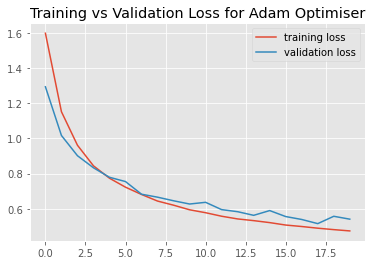

In [ ]:
# Training with Adam Optimizer
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=LR, betas=BETAS, weight_decay=WD)
train(optimizer)
optimizers.append(optimizer)

Starting to train with optimizer:  SGD
epoch : 1
training loss: 1.7913, acc 32.6320 
validation loss: 1.4189, validation acc 46.9200 Time: 30.1711 seconds
epoch : 2
training loss: 1.2560, acc 53.8440 
validation loss: 1.1240, validation acc 59.5700 Time: 65.0428 seconds
epoch : 3
training loss: 0.9992, acc 64.1160 
validation loss: 0.8959, validation acc 68.4500 Time: 100.7585 seconds
epoch : 4
training loss: 0.8209, acc 70.9240 
validation loss: 0.8019, validation acc 72.2600 Time: 135.3929 seconds
epoch : 5
training loss: 0.7067, acc 75.2680 
validation loss: 0.6708, validation acc 76.8200 Time: 170.6507 seconds
epoch : 6
training loss: 0.6300, acc 78.1060 
validation loss: 0.6388, validation acc 78.1300 Time: 205.4649 seconds
epoch : 7
training loss: 0.5643, acc 80.4200 
validation loss: 0.5942, validation acc 79.6900 Time: 240.9250 seconds
epoch : 8
training loss: 0.5242, acc 81.8940 
validation loss: 0.5585, validation acc 81.0200 Time: 275.5198 seconds
epoch : 9
training loss: 0.

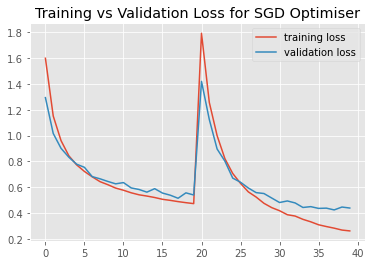

In [ ]:
# Training with SGD Optimizer
net = Net().to(device)
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM)

train(optimizer)
optimizers.append(optimizer)

Starting to train with optimizer:  Adagrad
epoch : 1
training loss: 1.4669, acc 45.5660 
validation loss: 1.2152, validation acc 55.7300 Time: 30.2992 seconds
epoch : 2
training loss: 1.1227, acc 59.3500 
validation loss: 1.0607, validation acc 61.4300 Time: 65.6716 seconds
epoch : 3
training loss: 0.9862, acc 64.3980 
validation loss: 0.9570, validation acc 65.2600 Time: 101.5596 seconds
epoch : 4
training loss: 0.9097, acc 67.6980 
validation loss: 0.9045, validation acc 67.6900 Time: 136.9159 seconds
epoch : 5
training loss: 0.8526, acc 69.5640 
validation loss: 0.8704, validation acc 69.2400 Time: 173.0276 seconds
epoch : 6
training loss: 0.8131, acc 71.1700 
validation loss: 0.8374, validation acc 70.2300 Time: 207.9732 seconds
epoch : 7
training loss: 0.7849, acc 72.0680 
validation loss: 0.8130, validation acc 71.1500 Time: 243.8784 seconds
epoch : 8
training loss: 0.7534, acc 73.2160 
validation loss: 0.7894, validation acc 71.8800 Time: 279.1582 seconds
epoch : 9
training loss

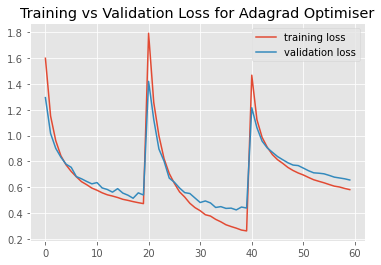

In [ ]:
# Training with Adgrad Optimizer
net = Net().to(device)
optimizer = optim.Adagrad(net.parameters(), lr=LR, weight_decay=0, initial_accumulator_value=0, eps=EPS)
train(optimizer)
optimizers.append(optimizer)

Starting to train with optimizer:  Adamax
epoch : 1
training loss: 1.5165, acc 43.3600 
validation loss: 1.1866, validation acc 56.6100 Time: 31.3787 seconds
epoch : 2
training loss: 1.0373, acc 62.8300 
validation loss: 0.9229, validation acc 66.7300 Time: 67.8829 seconds
epoch : 3
training loss: 0.8316, acc 70.6200 
validation loss: 0.7770, validation acc 72.7600 Time: 105.0786 seconds
epoch : 4
training loss: 0.7234, acc 74.8900 
validation loss: 0.7276, validation acc 74.8100 Time: 141.7740 seconds
epoch : 5
training loss: 0.6538, acc 77.2340 
validation loss: 0.6385, validation acc 78.2200 Time: 178.4377 seconds
epoch : 6
training loss: 0.5915, acc 79.5500 
validation loss: 0.6020, validation acc 79.6200 Time: 215.0639 seconds
epoch : 7
training loss: 0.5445, acc 81.0240 
validation loss: 0.5804, validation acc 80.4700 Time: 251.9172 seconds
epoch : 8
training loss: 0.5039, acc 82.6520 
validation loss: 0.5627, validation acc 80.6500 Time: 288.5302 seconds
epoch : 9
training loss:

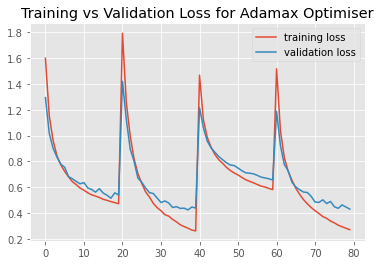

In [ ]:
# Training with Adamax Optimizer
net = Net().to(device)
optimizer = optim.Adamax(net.parameters(), lr=LR) 
train(optimizer)
optimizers.append(optimizer)

Starting to train with optimizer:  ASGD
epoch : 1
training loss: 2.2946, acc 12.5840 
validation loss: 2.2846, validation acc 15.9200 Time: 29.8987 seconds
epoch : 2
training loss: 2.2690, acc 18.5420 
validation loss: 2.2462, validation acc 21.3400 Time: 64.9801 seconds
epoch : 3
training loss: 2.2058, acc 22.1200 
validation loss: 2.1485, validation acc 24.2400 Time: 100.5114 seconds
epoch : 4
training loss: 2.0864, acc 24.8200 
validation loss: 2.0241, validation acc 27.3000 Time: 135.8214 seconds
epoch : 5
training loss: 1.9765, acc 28.7180 
validation loss: 1.9167, validation acc 31.3200 Time: 171.2652 seconds
epoch : 6
training loss: 1.8654, acc 31.7200 
validation loss: 1.8035, validation acc 33.6100 Time: 205.9702 seconds
epoch : 7
training loss: 1.7669, acc 34.2320 
validation loss: 1.7233, validation acc 35.7800 Time: 241.7500 seconds
epoch : 8
training loss: 1.6989, acc 36.5280 
validation loss: 1.6670, validation acc 37.8300 Time: 276.9319 seconds
epoch : 9
training loss: 1

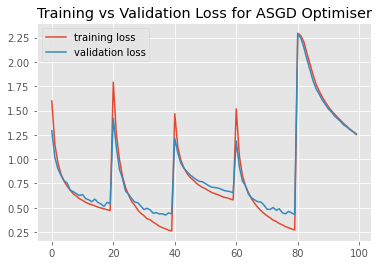

In [ ]:
# Training with ASGD Optimizer
net = Net().to(device)
optimizer = optim.ASGD(net.parameters(), lr=LR)
train(optimizer)
optimizers.append(optimizer)

In [ ]:
# # Training with LBFGS Optimizer
# net = Net().to(device)
# optimizer = optim.LBFGS(net.parameters(), lr=LR_LBFGS)
# train(optimizer)
# optimizers.append(optimizer)

Starting to train with optimizer:  Rprop
epoch : 1
training loss: 48469091.5474, acc 10.0540 
validation loss: 319.9591, validation acc 10.0000 Time: 43.7086 seconds
epoch : 2
training loss: 380.3613, acc 10.1160 
validation loss: 309.2502, validation acc 9.5500 Time: 92.5036 seconds
epoch : 3
training loss: 354.5274, acc 10.0640 
validation loss: 294.1832, validation acc 10.2700 Time: 141.0661 seconds
epoch : 4
training loss: 317.6582, acc 9.8800 
validation loss: 275.4603, validation acc 10.1000 Time: 189.8603 seconds
epoch : 5
training loss: 297.1988, acc 10.2800 
validation loss: 350.4280, validation acc 10.3000 Time: 238.7689 seconds
epoch : 6
training loss: 279.1254, acc 10.3540 
validation loss: 284.1248, validation acc 9.9300 Time: 287.3396 seconds
epoch : 7
training loss: 287.3170, acc 9.8200 
validation loss: 260.4645, validation acc 9.8100 Time: 336.2822 seconds
epoch : 8
training loss: 293.2382, acc 10.0840 
validation loss: 262.3250, validation acc 9.8100 Time: 384.8666 se

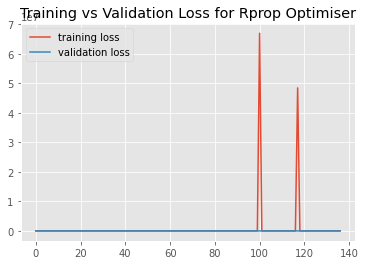

In [ ]:
# Training with Rprop Optimizer
net = Net().to(device)
optimizer = optim.Rprop(net.parameters(), lr=LR_RPROP)
train(optimizer)
optimizers.append(optimizer)

In [ ]:
len(state_dictionaries)

6

In [ ]:
def getOptimizerStateValues(opt, dict):
    return dict[type(opt).__name__]

def getOptimizerKey(opt):
    return type(opt).__name__

torch.save({
    getOptimizerKey(optimizers[0]): getOptimizerStateValues(optimizers[0], state_dictionaries),
    getOptimizerKey(optimizers[1]): getOptimizerStateValues(optimizers[1], state_dictionaries),
    getOptimizerKey(optimizers[2]): getOptimizerStateValues(optimizers[2], state_dictionaries),
    getOptimizerKey(optimizers[3]): getOptimizerStateValues(optimizers[3], state_dictionaries),
    getOptimizerKey(optimizers[4]): getOptimizerStateValues(optimizers[4], state_dictionaries),
    getOptimizerKey(optimizers[5]): getOptimizerStateValues(optimizers[5], state_dictionaries),
    # getOptimizerKey(optimizers[6]): getOptimizerStateValues(optimizers[6], state_dictionaries)
}, PATH)